# Large scale text analysis with deep learning

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0). 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
# !curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
# !tar -xvzf ./Train_rev1.csv.tar.gz
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

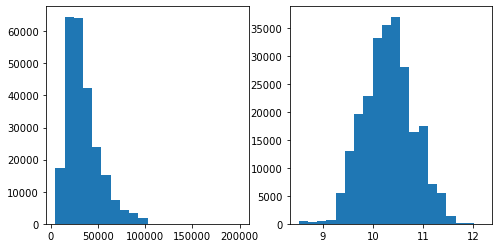

In [3]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [4]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
174660,71435071,Business Development Executive,"This is an out and out new business role, work...","Redhill, Surrey Surrey South East",Redhill,NaN,permanent,Michael Page Sales,Sales Jobs,25000 to 30000 per annum,27500,totaljobs.com,10.221977
216109,72244274,"HR Advisor / HR Officer, East Midlands **** p...","Employment Law Advisor Leicestershire, easily...",Leicestershire East Midlands,Leicestershire,NaN,permanent,Ashdown Group,HR & Recruitment Jobs,22000 - 28000 per annum,25000,totaljobs.com,10.126671
53468,68673782,Graduate Product Assistant **** ****k,Graduate Product Assistant **** **** Warwicks...,Warwickshire West Midlands,Warwickshire,NaN,permanent,Blue Skies Marketing Recruitment,Retail Jobs,17500 to 21000 per annum,19250,totaljobs.com,9.865318


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [5]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [6]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

# see task above
preprocess = lambda text: ' '.join(tokenizer.tokenize(str(text).lower()))
data["FullDescription"] = list(map(preprocess, data["FullDescription"]))
data["Title"] = list(map(preprocess, data["Title"]))

Now we can assume that our text is a space-separated list of tokens:

In [7]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [8]:
# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
from functools import reduce
from collections import Counter

def safe_extend(x, y):
    if x is None:
        return y
    x.extend(y)
    return x

words = list(
    reduce(
        safe_extend,
        map(
            lambda x: x.split(), 
            np.concatenate([data["Title"].values, data["FullDescription"].values])
       )
    )
)

token_counts = Counter(words)

# hint: you may or may not want to use collections.Counter

In [9]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


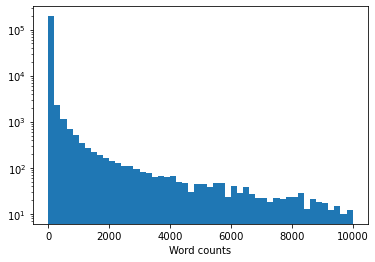

In [10]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Now filter tokens a list of all tokens that occur at least 10 times.

In [11]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = dict(filter(lambda item: item[1] > min_count, token_counts.items()))

In [12]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 32456
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [13]:
token_to_id = dict(zip(tokens, range(len(tokens))))

In [14]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [15]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [16]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10273 28655  2055     1     1]
 [14296  2700     1     1     1]
 [26272  9698    14 14484 10270]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [17]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [18]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [19]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [20]:
make_batch(data_train[:3], max_len=10)

{'Title': array([[26272, 28401, 31999,     1,     1,     1,     1],
        [27772,   187, 18227, 19056, 14801, 22008,  3848],
        [10082, 28895, 16876,    31,  8281, 27695,    61]], dtype=int32),
 'FullDescription': array([[26272, 28401, 31999, 31307,   909, 26272, 28401, 31999, 15662,
         31307],
        [27772,   187, 18227, 19056, 14801, 22008,  3848, 24230,   836,
            77],
        [29212, 20872, 19591,  6092, 15662,  7773, 26125,   909, 28895,
         16876]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32)}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use __[Keras Functional API](https://keras.io/models/model/)__.

In [21]:
import keras
import keras.layers as L

In [22]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    f_title = L.LSTM(hid_size)(tf.expand_dims(l_title, -1))
    f_descr = L.LSTM(hid_size)(tf.expand_dims(l_descr, -1))
    output_layer = L.Dense(1)(tf.concat([f_title, f_descr, l_categ], axis=1))
    # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model
    

In [23]:
model = build_model()
model.summary()

dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
FullDescription (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)     (None, None, 1)      0           Title[0][0]                      
__________________________________________________________________________________________________
tf.expand_dims_1 (TFOpLambda)   (None, None, 1)      0           FullDescription[0][0]            
______________________________________________________________________________________________

/home/rafasus/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['Log1pSalary'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [24]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [25]:
batch_size = 256
epochs = 10            # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()

model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

/home/rafasus/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 16s 146ms/step - loss: 65.7108 - mean_absolute_error: 7.4614 - val_loss: 0.3328 - val_mean_absolute_error: 0.4433
Epoch 2/10
100/100 [==============================] - 14s 141ms/step - loss: 0.3086 - mean_absolute_error: 0.4250 - val_loss: 0.2811 - val_mean_absolute_error: 0.4091
Epoch 3/10
100/100 [==============================] - 14s 143ms/step - loss: 0.2727 - mean_absolute_error: 0.4038 - val_loss: 0.2701 - val_mean_absolute_error: 0.4020
Epoch 4/10
100/100 [==============================] - 14s 143ms/step - loss: 0.2780 - mean_absolute_error: 0.4071 - val_loss: 0.2603 - val_mean_absolute_error: 0.3956
Epoch 5/10
100/100 [==============================] - 14s 141ms/step - loss: 0.2542 - mean_absolute_error: 0.3942 - val_loss: 0.2478 - val_mean_absolute_error: 0.3887
Epoch 6/10
100/100 [==============================] - 14s 141ms/step - loss: 0.2401 - mean_absolute_error: 0.3860 - val_loss: 0.2353 - val_mean_absolute_error: 0.38

In [26]:
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error
    
print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val');

Train results:
Mean square error: 0.20299
Mean absolute error: 0.35487
Val results:
Mean square error: 0.20197
Mean absolute error: 0.35484


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [27]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 

    *predictions_drop_one_token, baseline_pred = model.predict(make_batch(data_drop_one_token))[:, 0]
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))

In [28]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [29]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [30]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

cleaning operative

12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

In [31]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model.predict(make_batch(data.iloc[i: i+1]))[0, 0]))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 242567
Salary (gbp): 950.8174


senior engineer / engineering maintenance manager

our client is a leading global manufacturing company . they are currently looking to recruit an experienced senior engineer to implement and manage a risk based maintenance strategy , developing continuous improvements to the plant and personnel , ensuring business objectives are met safely , on time and on budget . you will lead and manage the maintenance department , ensuring the safe introduction of new equipment . an expert knowledge of heavy industry engineering process and operations is essential as well as an understanding of comah , ideally gained within a similar plant . the successful candidate will be qualified to degree level or equivalent in a relevant subject with a wealth of practical experience . a natural leader , you will motivate and encourage those around you , ensuring standards are maintained and area s for improvement are identified . you must be familiar with computerized maintenance management systems and a knowledge of sap , pm and mm would be advantageous . in return you will be offered a competitive salary and the opportunity to put your own stamp on this key role . this role is based in redcar , commutable from newcastle , durham , middlesbrough , stockton on tees and darlington .

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)

## Final task: improve over it

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time - our `L.GlobalMaxPool1D`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not want to use __`.get_keras_embedding()`__ method for word2vec
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback](https://keras.io/api/callbacks/early_stopping/).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!

In [32]:
def plot_history(history):
    plt.figure(figsize=(16, 7))
    plt.subplot(121)
    plt.yscale('log')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.subplot(122)
    plt.yscale('log')
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.show()

In [33]:
def build_cnn_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    f_title = L.Conv1D(8, kernel_size=3)(tf.expand_dims(l_title, -1))
    f_title = L.BatchNormalization()(f_title)
    f_title = L.ReLU()(f_title)
    f_title = L.Conv1D(16, kernel_size=3)(f_title)
    f_title = L.BatchNormalization()(f_title)
    f_title = L.ReLU()(f_title)
    f_title = L.Conv1D(32, kernel_size=3)(f_title)
    f_title = L.GlobalAveragePooling1D()(f_title)
    
    f_descr = L.Conv1D(8, kernel_size=3)(tf.expand_dims(l_descr, -1))
    f_title = L.BatchNormalization()(f_title)
    f_title = L.ReLU()(f_title)
    f_descr = L.Conv1D(16, kernel_size=3)(f_descr)
    f_title = L.BatchNormalization()(f_title)
    f_title = L.ReLU()(f_title)
    f_descr = L.Conv1D(32, kernel_size=3)(f_descr)
    f_descr = L.MaxPool1D()(f_descr)
    f_descr = L.Conv1D(64, kernel_size=3)(f_descr)
    f_title = L.BatchNormalization()(f_title)
    f_title = L.ReLU()(f_title)
    f_descr = L.Conv1D(128, kernel_size=3)(f_descr)
    f_title = L.BatchNormalization()(f_title)
    f_title = L.ReLU()(f_title)
    f_descr = L.Conv1D(256, kernel_size=3)(f_descr)
    f_descr = L.GlobalAveragePooling1D()(f_descr)
    output_layer = L.Dense(1)(tf.concat([f_title, f_descr, l_categ], axis=1))
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
tf.expand_dims_4 (TFOpLambda)   (None, None, 1)      0           Title[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 8)      32          tf.expand_dims_4[0][0]           
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, 8)      32          conv1d[0][0]                     
____________________________________________________________________________________________

100/100 [==============================] - 15s 154ms/step - loss: 24.5137 - mean_absolute_error: 4.1228 - val_loss: 29.0590 - val_mean_absolute_error: 4.8316
Epoch 10/50
100/100 [==============================] - 15s 156ms/step - loss: 23.8493 - mean_absolute_error: 4.1150 - val_loss: 23.3749 - val_mean_absolute_error: 4.1924
Epoch 11/50
100/100 [==============================] - 14s 141ms/step - loss: 22.3451 - mean_absolute_error: 3.9617 - val_loss: 25.1298 - val_mean_absolute_error: 4.4454
Epoch 12/50
100/100 [==============================] - 15s 147ms/step - loss: 22.0465 - mean_absolute_error: 3.9498 - val_loss: 21.3977 - val_mean_absolute_error: 4.0009
Epoch 13/50
100/100 [==============================] - 15s 146ms/step - loss: 20.2872 - mean_absolute_error: 3.7967 - val_loss: 25.6925 - val_mean_absolute_error: 4.5665
Epoch 14/50
100/100 [==============================] - 14s 141ms/step - loss: 18.9238 - mean_absolute_error: 3.6698 - val_loss: 19.3883 - val_mean_absolute_error:

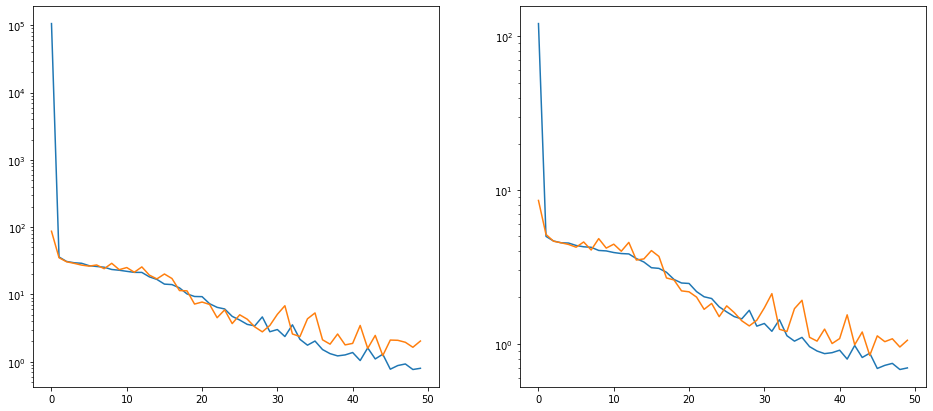

In [34]:
batch_size = 256
epochs = 50
steps_per_epoch = 100

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_mean_absolute_error",
    patience=8,
    restore_best_weights=True
)
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='./cnn_model.hdf5',
    monitor="val_mean_absolute_error"
)
model = build_cnn_model()
model.summary()
cnn_history = model.fit_generator(
    iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
    validation_steps=data_val.shape[0] // batch_size,
    callbacks=[early_stop, checkpoint]
)
plot_history(cnn_history)

In [35]:
def build_brnn_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    f_title = L.LSTM(hid_size)(tf.expand_dims(l_title, -1))
    fr_title = L.LSTM(hid_size, go_backwards=True)(tf.expand_dims(l_title, -1))
    f_descr = L.LSTM(hid_size)(tf.expand_dims(l_descr, -1))
    fr_descr = L.LSTM(hid_size, go_backwards=True)(tf.expand_dims(l_title, -1))
    output_layer = L.Dense(1)(
        tf.concat([f_title, fr_title, 
        f_descr, fr_descr, 
        l_categ], axis=1)
    )

    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
FullDescription (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
tf.expand_dims_6 (TFOpLambda)   (None, None, 1)      0           Title[0][0]                      
__________________________________________________________________________________________________
tf.expand_dims_7 (TFOpLambda)   (None, None, 1)      0           Title[0][0]                      
____________________________________________________________________________________________

100/100 [==============================] - 15s 151ms/step - loss: 0.1542 - mean_absolute_error: 0.3073 - val_loss: 0.1505 - val_mean_absolute_error: 0.3043
Epoch 30/30
100/100 [==============================] - 15s 149ms/step - loss: 0.1472 - mean_absolute_error: 0.2971 - val_loss: 0.1502 - val_mean_absolute_error: 0.3024


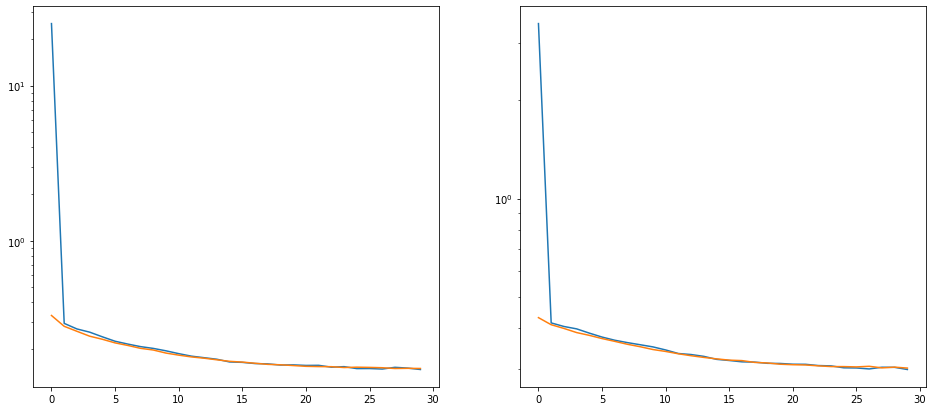

In [36]:
batch_size = 256
epochs = 30
steps_per_epoch = 100

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_mean_absolute_error",
    patience=5,
    restore_best_weights=True
)
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='./brnn_model.hdf5',
    monitor="val_mean_absolute_error"
)
model = build_brnn_model()
model.summary()
brnn_history = model.fit_generator(
    iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
    validation_steps=data_val.shape[0] // batch_size,
    callbacks=[early_stop, checkpoint]
)
plot_history(brnn_history)

In [37]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

def vectorize_sum(comment):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')
    
    for word in preprocess(comment).split():
        if word in embeddings.key_to_index:
            features += embeddings.vectors[embeddings.key_to_index[word]]
    
    return features

/home/rafasus/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [38]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(
        np.stack([vectorize_sum(text) for text in data["Title"].values]))
    batch["FullDescription"] = as_matrix(
        np.stack([vectorize_sum(text) for text in data["FullDescription"].values]))
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [39]:
def build_dense_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[300], name="Title")
    l_descr = L.Input(shape=[300], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    f_title = L.Dense(hid_size)(l_title)
    f_descr = L.Dense(hid_size)(l_descr)
    output_layer = L.Dense(hid_size)(tf.concat([f_title, f_descr,l_categ], axis=1))
    output_layer = L.Dense(1)(output_layer)

    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Title (InputLayer)              [(None, 300)]        0                                            
__________________________________________________________________________________________________
FullDescription (InputLayer)    [(None, 300)]        0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 64)           19264       Title[0][0]                      
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           19264       FullDescription[0][0]            
____________________________________________________________________________________________

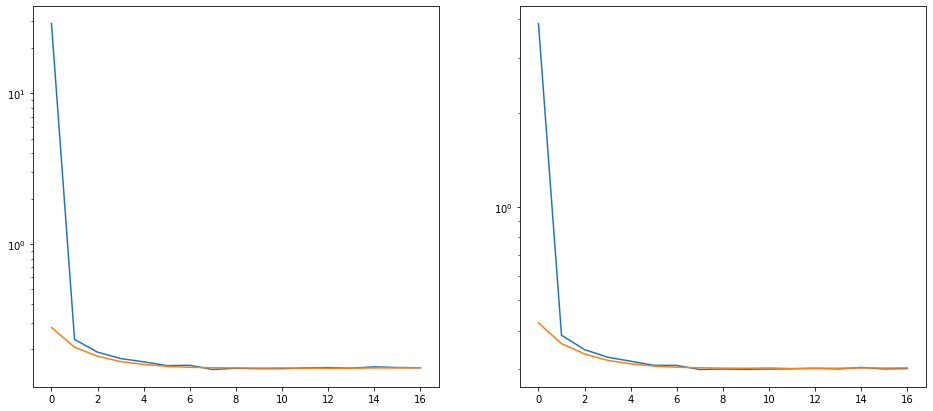

In [40]:
batch_size = 256
epochs = 30
steps_per_epoch = 100

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_mean_absolute_error",
    patience=5,
    restore_best_weights=True
)
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='./dense_model.hdf5',
    monitor="val_mean_absolute_error"
)
model = build_dense_model()
model.summary()
dense_history = model.fit_generator(
    iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
    validation_steps=data_val.shape[0] // batch_size,
    callbacks=[early_stop, checkpoint]
)
plot_history(dense_history)